In [1]:
# pip install happybase setuptools pandas matplotlib seaborn plotly nbformat

# Creating Dataframe based on Data consumed From Hbase table "MOVIES"

In [7]:
import pandas as pd
import happybase

# HBase server details
hbase_host = '192.168.117.152'
hbase_table = 'movies'

# Connect to HBase
connection = happybase.Connection(hbase_host)

# Open the table
table = connection.table(hbase_table)

# Scan HBase table and fetch data
data = []
for key, value in table.scan(limit=100):  # Limit to 100 rows
    # Decode row key (could be an ID or date)
    row_key = key.decode('utf-8')
    
    # Decode column names and values
    row_data = {col.decode('utf-8'): value[col].decode('utf-8') for col in value}
    
    # Include the row key (e.g., ID) in the row data
    row_data['row_key'] = row_key
    
    data.append(row_data)

# Create DataFrame from HBase data
df = pd.DataFrame(data)
df['stats:score'] = pd.to_numeric(df['stats:score'], errors='coerce')
df['stats:number_of_votes'] = pd.to_numeric(df['stats:number_of_votes'], errors='coerce')
# Close the HBase connection
connection.close()

# Analytics 1: Top Rated Movies
df_top_rated_movies = df.sort_values(['stats:score','row_key'],ascending=[False,True])[['row_key','stats:score','stats:number_of_votes']].head(10)
df_top_rated_movies.rename(columns={'row_key':'movie_title','stats:score':'rating','stats:number_of_votes':'total_votes'}, inplace=True)

# Analytics 2: Top Most Voted Movies
df_top_voted_movies = df.sort_values(['stats:number_of_votes','row_key'],ascending=[False,True])[['row_key','stats:number_of_votes','stats:score']].head(10)
df_top_voted_movies.rename(columns={'row_key':'movie_title','stats:number_of_votes':'total_votes','stats:score':'rating'}, inplace=True)

# Analytics 3: Total number of movies by genre
df_movies_by_genre = df.groupby('info:main_genre').size().reset_index(name='count')
df_movies_by_genre.rename(columns={'info:main_genre':'genre','count':'total'}, inplace=True)
df_movies_by_genre['total'] = pd.to_numeric(df_movies_by_genre['total'], errors='coerce')

# Printing Data Frame collected from HBase
print(df_top_rated_movies.to_string(index=False))
print(df_top_voted_movies.to_string(index=False))
print(df_movies_by_genre.to_string(index=False))


                    movie_title  rating  total_votes
                       Big Fish     8.0       435503
              Blade Runner 2049     8.0       539864
     Dave Chappelle: The Closer     8.0        24903
                          Dev.D     7.9        30389
                   Free to Play     7.9        13308
            I Am Not Your Negro     7.9        21632
14 Peaks: Nothing Is Impossible     7.8        22858
                     Awakenings     7.8       137549
                          Badla     7.8        27130
                        Dunkirk     7.8       619645
               movie_title  total_votes  rating
                   Dunkirk       619645     7.8
                      Argo       600392     7.7
         Blade Runner 2049       539864     8.0
             Don't Look Up       498447     7.2
                  Big Fish       435503     8.0
How to Train Your Dragon 2       327565     7.8
             Donnie Brasco       300073     7.7
                   Gattaca       

# 1. Top Rated Movies

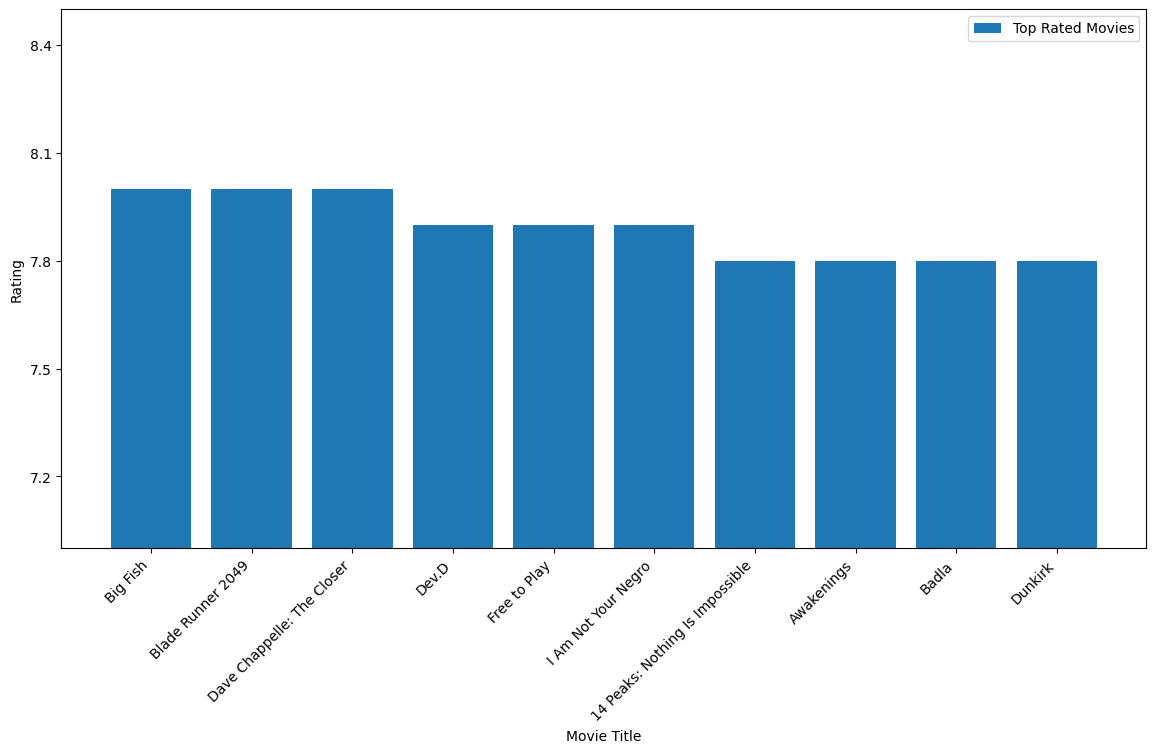

In [13]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))
plt.bar(df_top_rated_movies['movie_title'], df_top_rated_movies['rating'], label='Top Rated Movies')
plt.title='Top Voted Movies with Rating'
plt.xlabel('Movie Title')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')  
plt.ylim(7,8.5)

# Set y-axis tick frequency to show fewer ticks
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=5))

plt.legend()
plt.show()


# 2. Top Voted Movies

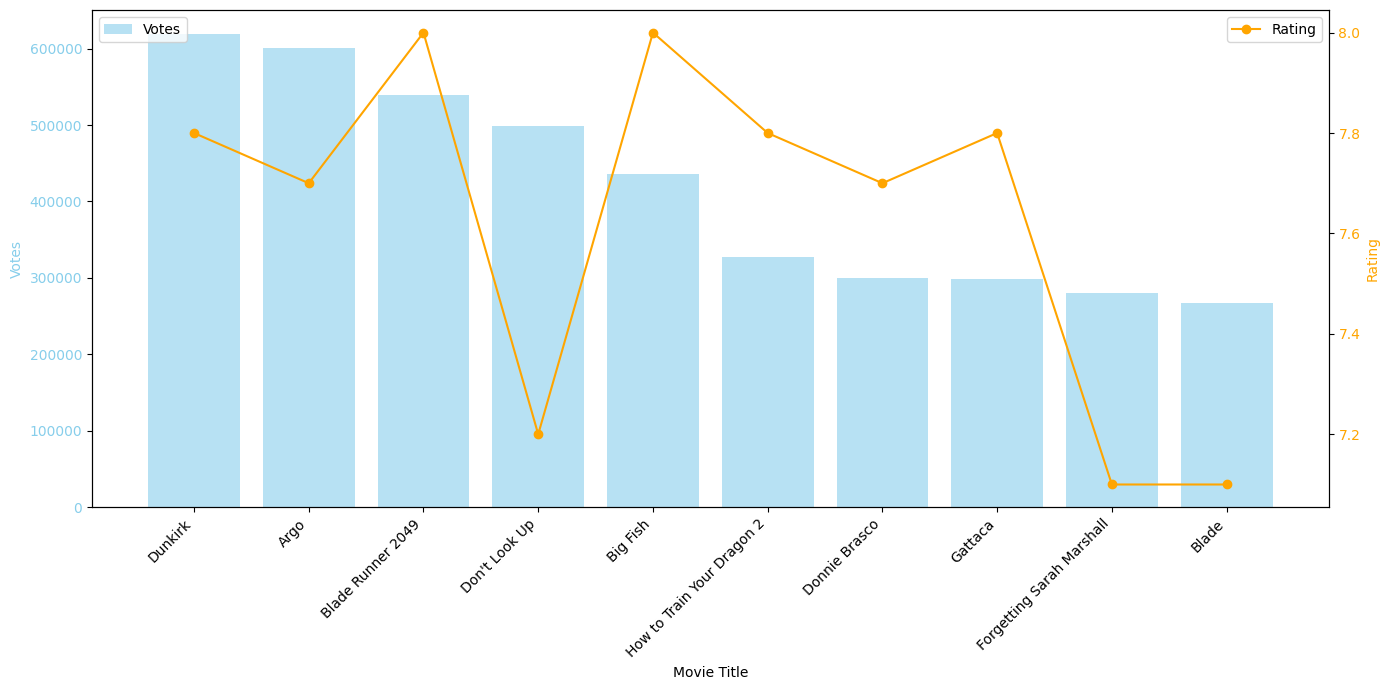

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Votes
ax1.bar(df_top_voted_movies['movie_title'], df_top_voted_movies['total_votes'], color='skyblue', alpha=0.6, label='Votes')
ax1.set_xlabel('Movie Title')
ax1.set_ylabel('Votes', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticks(range(len(df_top_voted_movies['movie_title'])))
ax1.set_xticklabels(df_top_voted_movies['movie_title'], rotation=45, ha='right')

# Plotting Rating
ax2 = ax1.twinx()
ax2.plot(df_top_voted_movies['movie_title'], df_top_voted_movies['rating'], color='orange', marker='o', label='Rating')
ax2.set_ylabel('Rating', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# plt.xticks(rotation=45)
plt.title='Top Voted Movies with Rating'
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# 3. Total Movie Distribution By Genere

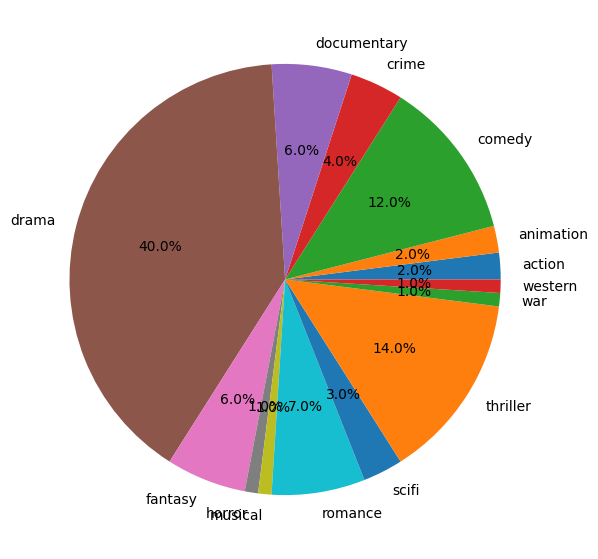

In [5]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))
plt.pie(df_movies_by_genre['total'], labels=df_movies_by_genre['genre'], autopct='%1.1f%%')
plt.title='Total Movie Distribution By Genere'
plt.show()
